In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

In [136]:
train_start_date = '2014-01-01'
train_end_date = '2022-12-31'
predict_start_date = '2023-01-01'
predict_end_date = '2023-12-31'

btc = yf.download('BTC-USD', start=train_start_date, end=predict_end_date)
print(btc.head())

[*********************100%***********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

              Volume  
Date                  
2014-09-17  21056800  
2014-09-18  34483200  
2014-09-19  37919700  
2014-09-20  36863600  
2014-09-21  26580100  


In [138]:
# Wyodrębnij dane do treningu i testowania na podstawie dat
train_data = btc.loc[train_start_date:train_end_date]['Close'].values.reshape(-1, 1)
test_data = btc.loc[predict_start_date:predict_end_date]['Close'].values.reshape(-1, 1)

In [139]:
# 3. Normalizacja danych
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [127]:
# 4. Podział danych na zestawy treningowe i testowe
train_size = int(len(btc_close_scaled) * 0.8)  # 80% danych do treningu
train_data, test_data = btc_close_scaled[0:train_size], btc_close_scaled[train_size:len(btc_close_scaled)]

In [128]:
# 5. Przygotowanie danych do LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [140]:
time_step = 100
X_train, y_train = create_dataset(train_data_scaled, time_step)
X_test, y_test = create_dataset(test_data_scaled, time_step)

In [141]:
# 6. Konwersja danych do formatu akceptowanego przez LSTM (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [142]:
# 7. Tworzenie modelu LSTM
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(100, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])
model.summary()

C:\Users\Michał\Desktop\crypto\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_31 (LSTM)                  │ (None, 100, 100)       │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,751 (483.40 KB)

 Trainable params: 123,751 (483.40 KB)

 Non-trainable params: 0 (0.00 B)

In [143]:
# Kompilacja modelu
model.compile(optimizer='adam', loss='mean_squared_error')

# 8. Trenowanie modelu
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - loss: 0.0195 - val_loss: 5.4958e-04
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - loss: 6.8015e-04 - val_loss: 4.8637e-04
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - loss: 6.1306e-04 - val_loss: 0.0012
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - loss: 6.9587e-04 - val_loss: 6.2910e-04
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 5.8463e-04 - val_loss: 4.1623e-04
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 5.3276e-04 - val_loss: 3.0385e-04
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 4.6262e-04 - val_loss: 0.0013
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 5.1950e-04 - val_loss: 4.0437e-04
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 4.5927e-04 - val_loss: 6.0886e-04
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 5.0899e-04 - val_loss: 3.1078e-04
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 3.4287

In [144]:
# 9. Predykcja na danych testowych
predictions = model.predict(X_test)
print(predictions[:10])

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
[[0.4328933 ]
 [0.44319418]
 [0.4428148 ]
 [0.44581723]
 [0.44724357]
 [0.44505867]
 [0.4446415 ]
 [0.4328922 ]
 [0.44407174]
 [0.42465934]]


In [145]:
# 10. Odwrotna transformacja dla porównania z rzeczywistymi danymi
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
print(y_test[:10])

[[30235.05859375]
 [30139.05273438]
 [30399.06640625]
 [30485.69921875]
 [30318.49609375]
 [30315.35546875]
 [29445.04492188]
 [30397.55273438]
 [28822.6796875 ]
 [28245.98828125]]


ConversionError: Failed to convert value(s) to axis units: '2023-01-01'

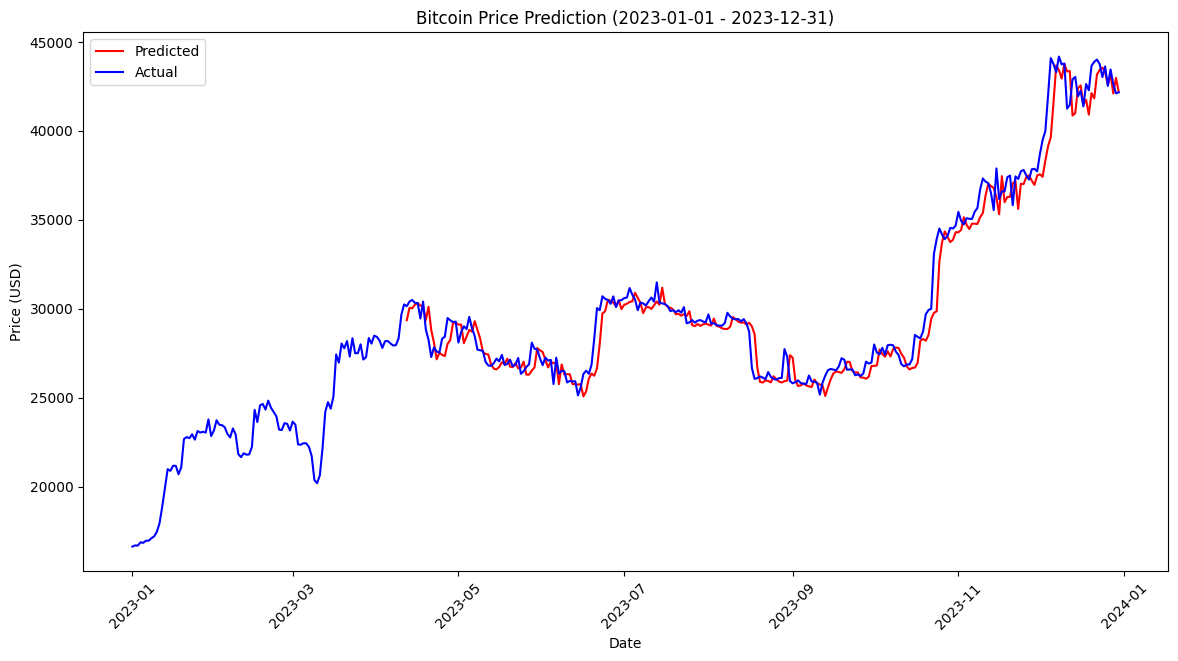

In [146]:
# Wizualizacja prognozy i rzeczywistych danych dla roku 2023
plt.figure(figsize=(14, 7))

# Daty testowe (dla prognoz)
test_dates = btc.loc[predict_start_date:predict_end_date].index[time_step + 1:len(predictions) + time_step + 1]

# Wykres przewidywań
plt.plot(test_dates, predictions, label='Predicted', color='red')

# Wyświetlanie rzeczywistych cen dla tego okresu
actual_prices = btc['Close'].loc[predict_start_date:predict_end_date]
actual_dates = actual_prices.index

plt.plot(actual_dates, actual_prices, label='Actual', color='blue')

plt.title(f'Bitcoin Price Prediction ({predict_start_date} - {predict_end_date})')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.xlim([predict_start_date, predict_end_date])  # Ustawiamy zakres osi X
plt.show()
